# Cross-Language Cluster

Code and data for preprint Showcase C / Figure 5

In [1]:
import pandas as pd
import metronome as met
import umap

In [2]:
%load_ext rpy2.ipython

In [3]:
from importlib.metadata import version

version("metronome")

'0.1.1'

## Import Data and Sample

In [4]:
df = pd.read_csv("data/crosslang_subset.csv", delimiter="\t")
df["metronome"] = df.metronome.str.replace("0", "w")
df["metronome"] = df.metronome.str.replace("1", "S")
df

,author,work,born,year,metronome,meter,lang
0,"Puškin, Aleksander Sergeevič",XXXVIII,NaN,1818.0,w.Sw.Sw.SwSw.|w.S.w.ww.S.wS.|w.w.Sw.wSw.Sw.|w....,I4,de
1,"Herder, Johann Gottfried",47.,NaN,1773.0,w.Sw.Sw.S.wS..|wSw.Sw.Sw.S.|w.S.w.Sw.S.|w.S.wS...,T5,de
2,"Holz, Arno",Er bekröhnt ihn mit einem Hirsch-Geweih,NaN,1883.0,wSw.w.w.S.|wS.w.w.w.S.|w.Sw.Sw.SwS...|w.Sw.SwS...,T5,de
3,"Ḥāfeẓ, Šams o'd-din Moḥammad",73.,NaN,1357.0,w.w.w.Sw.w.wS.|w.Sw.S.ww.w.Sw.|wS.wS.w.w.w.S.w...,I4,de
4,"Fontane, Theodor",1.,NaN,1856.0,w.Sw.Sw.Sw.Sw..|w.Sw.Sw.w.wS..|w.SwSw.S.wS.w.|...,I4,de
...,...,...,...,...,...,...,...
67935,"Calma, Marie",V parku.,1881.0,1921.0,w.Sw.Sww.w.Sw.Sw.Sw.|S.w.w.Sw.Sww.w.S.w.|w.Sww...,I5,cs
67936,"Calma, Marie",Za radostí.,1881.0,1921.0,S.S.www.Sw.S.www.|w.Sw.Sw.S.w.Sw.w.|w.Sw.Sw.S....,I5,cs
67937,"Calma, Marie",To's nebyl ty!,1881.0,1921.0,w.Sw.S.w.Sw.S.w.Sw.|w.Sww.w.Sw.Sw.Sw.|w.Sw.w.w...,I5,cs
67938,"Calma, Marie",Hvězdnatá noc.,1881.0,1921.0,w.Sw.Sw.Sw.Sw.Sw.|w.Sw.S.w.Swww.Sw.|w.S.ww.w.S...,I5,cs


In [5]:
df.groupby("lang")["meter"].value_counts()

lang  meter
cs    I5       17314
      T4        9317
      I4        6525
      I4_3      5869
      T5        3036
      T4_3      2355
de    I4        4225
      T4        4222
      I5        4016
      T5        1760
      I4_3       536
      T4_3       413
ru    I4        4415
      T4        1957
      I5        1264
      T5         275
      T4_3       262
      I4_3       179
Name: meter, dtype: int64

In [6]:
full_sample = df.groupby(["lang", "meter"]).sample(179, random_state=42)

## Set up Metronome Scorer and create distance matrix

In [7]:
# Match dict - bonus for matches, penalty for mismatches
md = {
    ("|", "|"): 3.5,
    ("w", "w"): 2.5,
    ("S", "S"): 3,
    (".", "."): 1,
    # penalise non-alignment at line ends more, because they're rarer. The idea
    # is to stop hendecasyllables being routinely padded out to match hexameter
    # lines
    ("|", "S"): -4,
    ("|", "w"): -4,
    ("|", "."): -4,
    ("w", "S"): -0.25,
    ("w", "."): 0,  # not sure. In theory we don't care if spaces mismatch
    ("S", "."): 0,  # because metre isn't based on a fixed number of words
}
# open and extend penalties for alignment gaps
open_penalty = -6
extend_penalty = -3

scorer = met.scoring.Scorer(
    match_dict=md, open_gap_score=open_penalty, extend_gap_score=extend_penalty
)

In [8]:
# This takes a lttle while! Even parallel, it's a 3922x3922 square matrix...

dm = scorer.dist_matrix_parallel(full_sample)

2024-04-19 11:27:27,533	INFO worker.py:1673 -- Started a local Ray instance.
(raylet) Spilled 2565 MiB, 1643 objects, write throughput 2203 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(raylet) Spilled 4608 MiB, 2952 objects, write throughput 1801 MiB/s.


## Do UMAP Clustering and Visualize

In [9]:
# now we can use the pairwise Bio distances as direct input to UMAP

umap_results = pd.DataFrame(full_sample[["born", "year", "meter", "lang"]])
umapper = umap.UMAP(
    n_neighbors=60,
    # project to 2 dimensions
    n_components=2,
    set_op_mix_ratio=0.85,
    metric="precomputed",
    # UMAP figures change with every run if not seeded
    random_state=2023,
)

u = umapper.fit_transform(dm)
umap_results["X"], umap_results["Y"] = u[:, 0], u[:, 1]

/Users/ben/venv/py39/lib/python3.9/site-packages/umap/umap_.py:1857: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/ben/venv/py39/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [10]:
# umap_results.to_csv("crosslang_cluster_umap.csv")

In [12]:
umap_results = pd.read_csv("crosslang_cluster_umap.csv", index_col=0)

In [13]:
umap_results

,born,year,meter,lang,X,Y
57722,1853.0,1897.0,I4,cs,-1.700702,-3.225563
63053,1875.0,1910.0,I4,cs,-0.833305,-2.860361
65275,1878.0,1906.0,I4,cs,-2.459853,-2.540634
39088,1864.0,1912.0,I4,cs,-2.709004,-2.471782
63953,1875.0,1928.0,I4,cs,-2.359072,-2.680427
...,...,...,...,...,...,...
22412,NaN,1823.0,T5,ru,1.566845,-2.881960
23300,NaN,1815.0,T5,ru,2.254837,-1.951408
18294,NaN,1832.0,T5,ru,2.717074,-2.560972
17701,NaN,1841.0,T5,ru,2.151611,-2.968079


In [14]:
umap_results["meter"] = umap_results.meter.str.replace("I", "Iambic ")
umap_results["meter"] = umap_results.meter.str.replace("T", "Trochaic ")

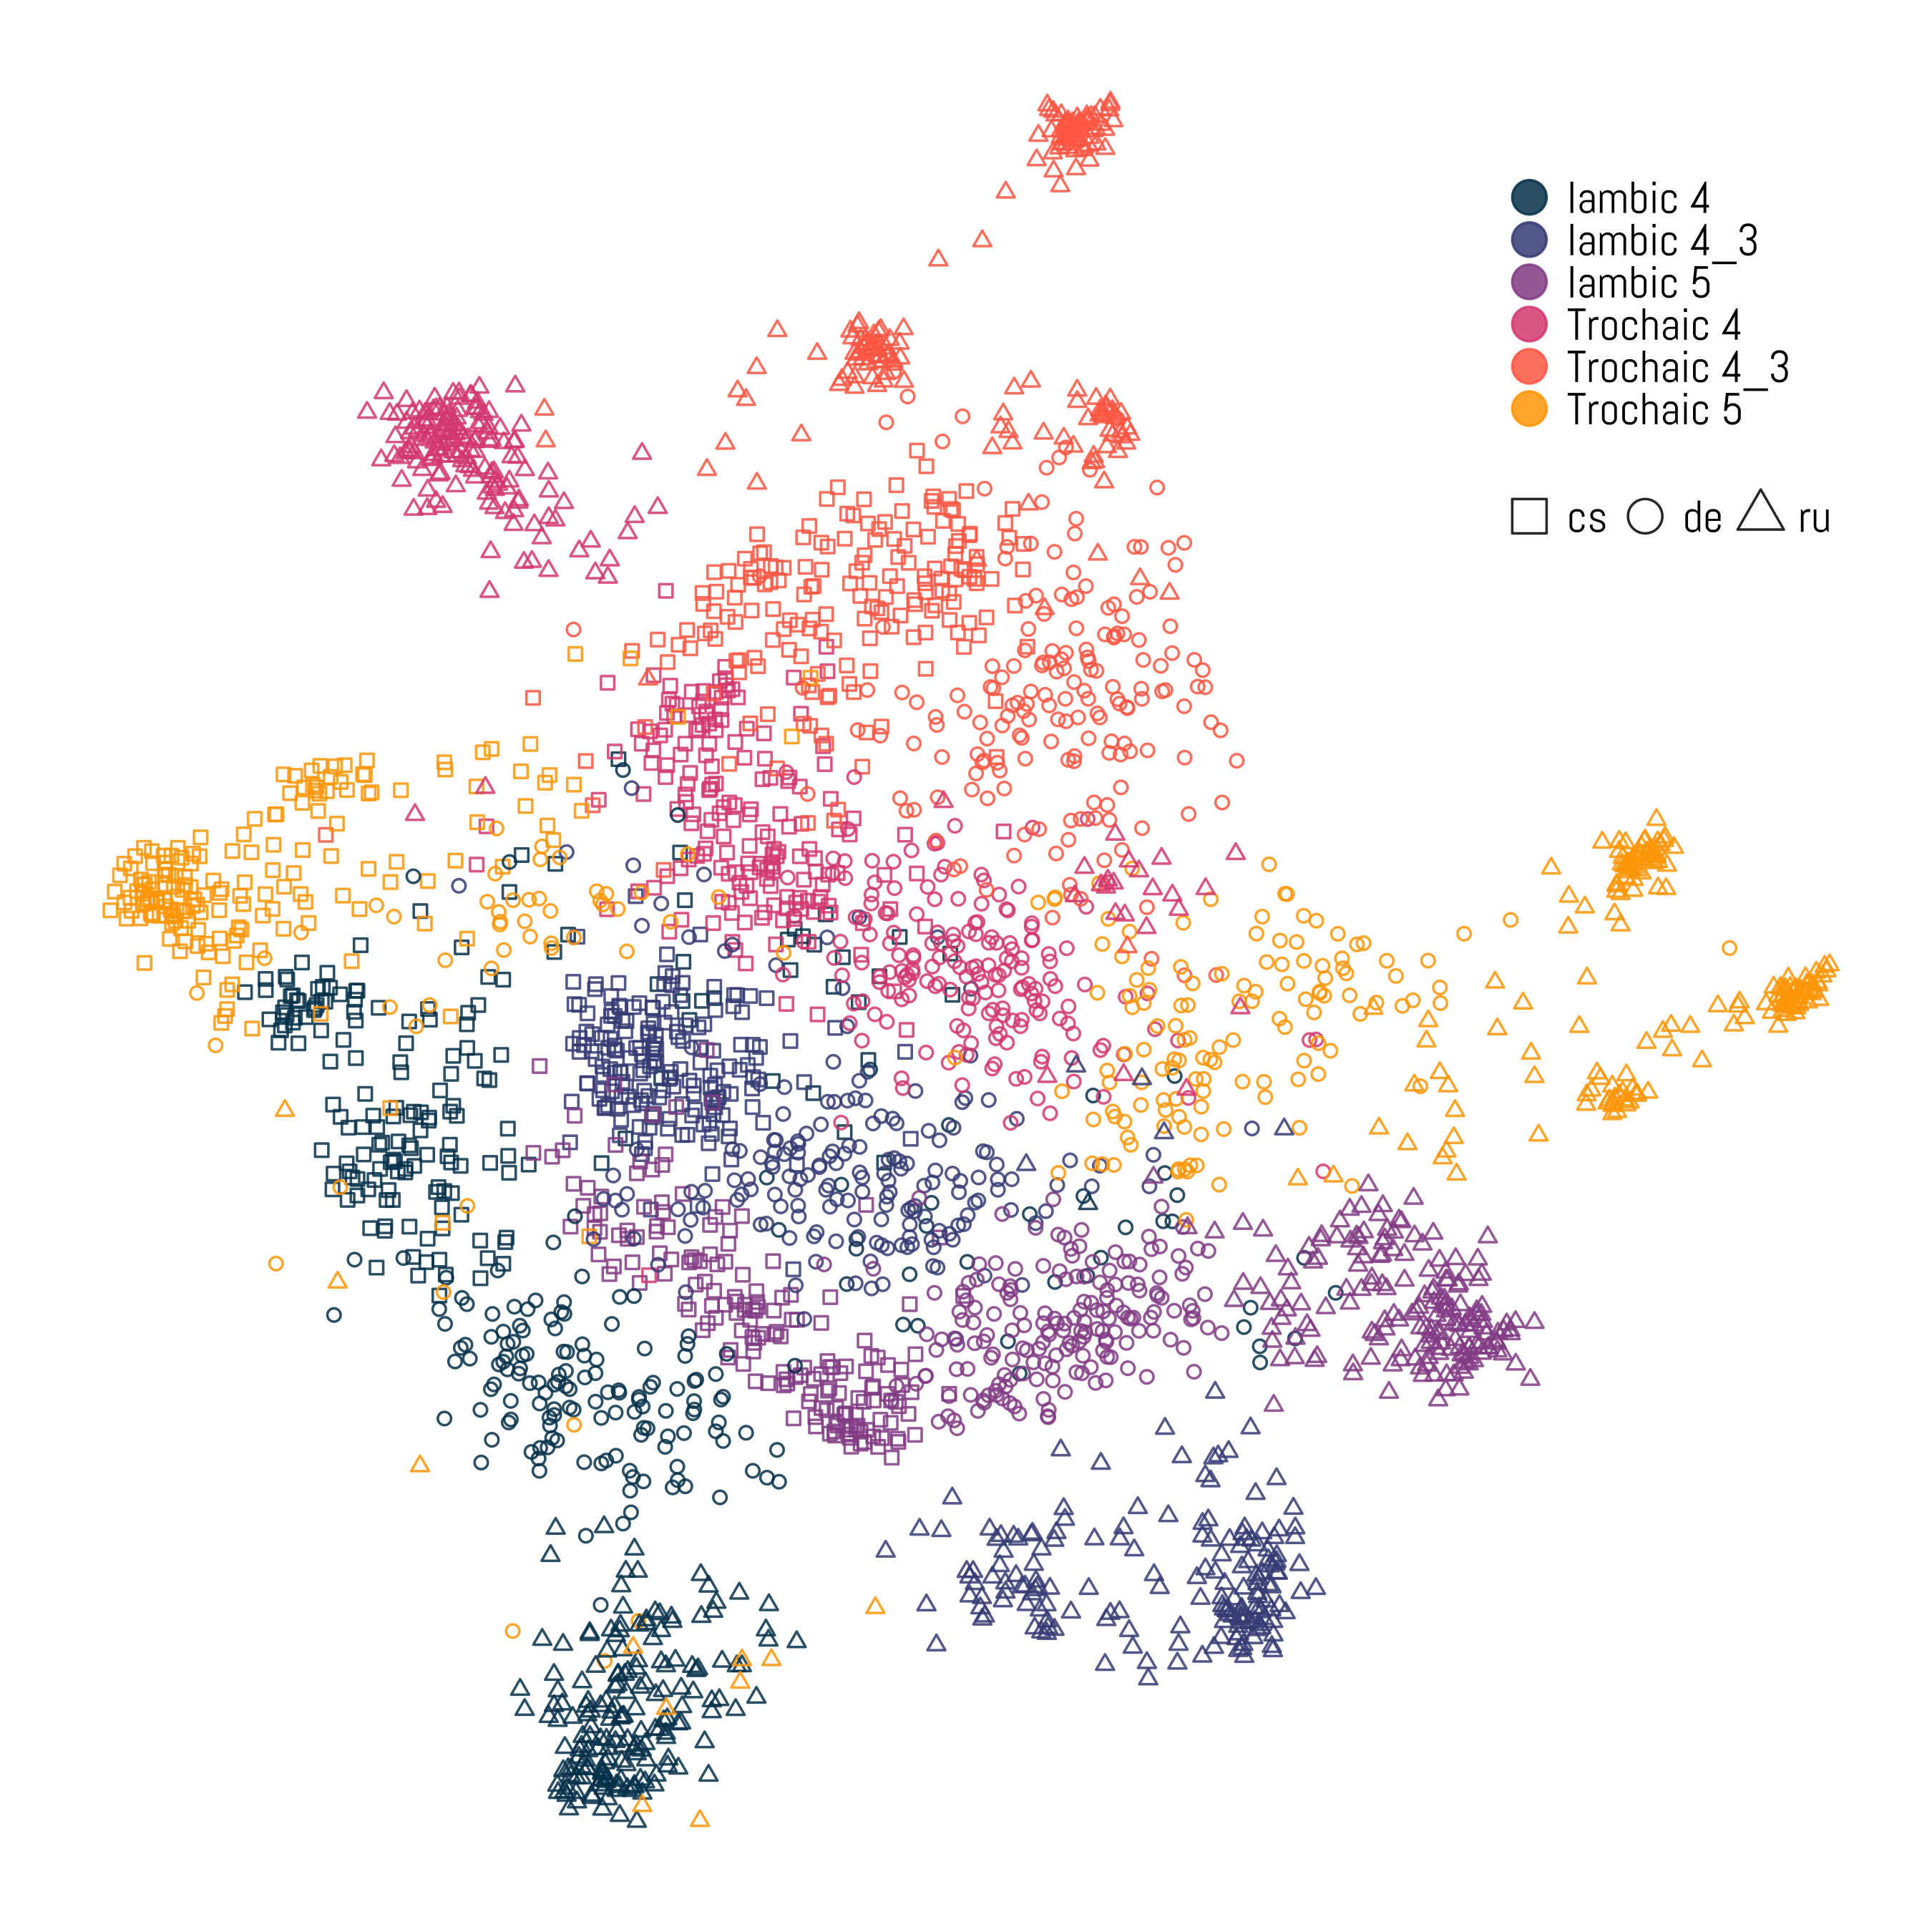

In [16]:
%%R -i umap_results -h 9 -w 9 -u in -r 300

library(ggplot2)
library(paletteer)
library(showtext)
font_add_google("Abel", "fnt")
showtext_auto()

bgcol = 'white'
fgcol = 'black'

plt <- c(
    "#003f5c",
    "#444e86",
    "#955196",
    "#dd5182",
    "#ff6e54",
    "#ffa600"
)
shapes <- c(0,1,2,15,16,17)

p <- ggplot(data=umap_results, aes(x=X, y=Y)) +
geom_point(alpha=0.85, stroke=0.6, aes(shape=lang,size=lang, color=meter)) +
theme_minimal() +
scale_colour_manual(values=plt) +
scale_shape_manual(values=shapes) +
scale_size_manual(values=c(1.3,1.3,1.3,1.3,1.3,1.3)*1.3,guide='none') +
theme(plot.title = element_text(margin = margin(b = 50))) +
guides(color = guide_legend(ncol=1,override.aes =list(size=5))) +
guides(shape = guide_legend(ncol=3,override.aes =list(size=5))) +

theme(
    panel.border = element_blank(),
    panel.background = element_rect(fill = bgcol,color=bgcol),
    plot.background = element_rect(fill = bgcol, color=bgcol),
    plot.title=element_text(margin=margin(0,0,0,0),size=20),
    legend.title=element_blank(),
    legend.position=c(0.87,0.82),
    legend.text=element_text(size=15),
    legend.key.size = unit(0, 'lines'),
    axis.title.x=element_blank(),
    axis.text.x=element_blank(),
    axis.ticks.x=element_blank(),
    axis.title.y=element_blank(),
    axis.text.y=element_blank(),
    axis.ticks.y=element_blank(),
    text=element_text(family="fnt",color=fgcol),
    panel.grid.minor=element_blank(),
    panel.grid.major=element_blank()
)

# fn <- "figures/crosslang_cluster.pdf"
# ggsave(fn, dpi=600, width=9, height=9, device=cairo_pdf)

p